# Transfer Learning Part 2 : Fine Tuning

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists, skipping download.")
from helper_functions import *
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
importTensorflow(memory=4090, precision=True)

[INFO] 'helper_functions.py' already exists, skipping download.
2.13.0
1 Physical GPUs, 1 Logical GPUs
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
<Policy "mixed_float16">


See how to use the pretrained models within tf.keras.applications

In [2]:
# Get 10% of training data
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [3]:
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"


## OLD WAY
# Create Image data generator
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

## NEW WAY
# Use image_dataset_from_directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=(128,128),
                                                                 label_mode="categorical",
                                                                 batch_size=16,
                                                                 shuffle=True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(128,128),
                                                                label_mode="categorical",
                                                                batch_size=16,
                                                                shuffle=True)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


None -> batch size(doesnt show the number usually)

(224,224,3) -> height,width,colour channel

(None,10) -> None = batch size |  10 -> number of classes in label tensor

In [4]:
# Check class names of dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [5]:
# See an example of a batch of data
for images,labels in train_data.take(1):
    print(images,labels)

tf.Tensor(
[[[[2.15000000e+01 1.35000000e+01 1.15000000e+01]
   [2.30000000e+01 1.50000000e+01 1.30000000e+01]
   [2.54921875e+01 1.74921875e+01 1.54921875e+01]
   ...
   [1.95312500e-02 1.52343750e+00 1.17187500e-02]
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]
   [2.00000000e+00 2.00000000e+00 2.00000000e+00]]

  [[2.29882812e+01 1.49882812e+01 1.29882812e+01]
   [2.44882812e+01 1.64882812e+01 1.44882812e+01]
   [2.69882812e+01 1.89882812e+01 1.69882812e+01]
   ...
   [3.96484375e+00 2.98828125e+00 1.17187500e-02]
   [2.00000000e+00 2.00000000e+00 2.34375000e-02]
   [1.02343750e+00 2.97656250e+00 1.02343750e+00]]

  [[2.40000000e+01 1.60000000e+01 1.40000000e+01]
   [2.59804688e+01 1.79804688e+01 1.59804688e+01]
   [2.65000000e+01 1.85000000e+01 1.65000000e+01]
   ...
   [9.30468750e+00 4.38281250e+00 9.60937500e-01]
   [2.98046875e+00 2.01953125e+00 0.00000000e+00]
   [1.00000000e+00 3.00000000e+00 0.00000000e+00]]

  ...

  [[3.21484375e+00 2.21484375e+00 3.71484375e+00]
   [3

In [6]:
#Try building a model using tf.keras.applications
# efficient_net_model = tf.keras.models.Sequential([
#     tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=(480,480,3)),
#     tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)
# ])
# efficient_net_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#                             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
#                             metrics=['accuracy'])
# efficientnet_history = efficient_net_model.fit(train_data,
#                                                epochs=5,
#                                                steps_per_epoch=len(train_data),
#                                                validation_data=test_data,
#                                                validation_steps=len(test_data))

### Using tf Functional model (different from Sequential model)

* Building a transfer learning model using keras Functional API
* Provides more flexibility compared to Seqquential model


In [7]:
# 1. Create a base model with tf.keras.applciations
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # include_top -> last layer (will be different for different datasets)

# 2. Freeze the base model, underlying pre-trained weights arent updated during training
base_model.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(128,128,3),
                               name="input_layer")

# 4. (Optional) -> if using resnet -> need to normalize inputs -> not needed for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x = base_model(inputs)

print("shape after passing inputs through base_model: "+str(x.shape))

# 6. Average pool the outputs of the base_model (aggregate all most of information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x)

print("Shape after GlobalAveragePooling2D: "+str(x.shape))

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax,name="output_layers")(x)

# 8. Combine input with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_0 = model_0.fit(train_data,
                        verbose=1,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data),
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16705208/16705208 [==============================] - 2s 0us/step
shape after passing inputs through base_model: (None, 4, 4, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240101-003021
Epoch 1/5
47/47 [==============================] - 7s 49ms/step - loss: 1.8822 - accuracy: 0.3933 - val_loss: 1.2745 - val_accuracy: 0.7000
Epoch 2/5
47/47 [==============================] - 1s 26ms/step - loss: 1.0145 - accuracy: 0.7720 - val_loss: 0.9187 - val_accuracy: 0.7719
Epoch 3/5
47/47 [==============================] - 1s 26ms/step - loss: 0.7536 - accuracy: 0.8133 - val_loss: 0.7844 - val_accuracy: 0.7797
Epoch 4/5
47/47 [==============================] - 1s 26ms/step - loss: 0.6055 - accuracy: 0.8573 - val_loss: 0.7499 - val_accuracy: 0.7688
Epoch 5/5
47/47 [==============================] - 1s 26ms/step - loss: 0.5152 - accuracy: 0.8760 - val_loss: 0.6748 - val_accuracy: 0.7922


In [8]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

157/157 [==============================] - 2s 15ms/step - loss: 0.6587 - accuracy: 0.8040


[0.6586843729019165, 0.8040000200271606]

In [9]:
base_model.layers

In [10]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [11]:
# Get summary of the model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [12]:
# Summary of full model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 average_global_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layers (Dense)       (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

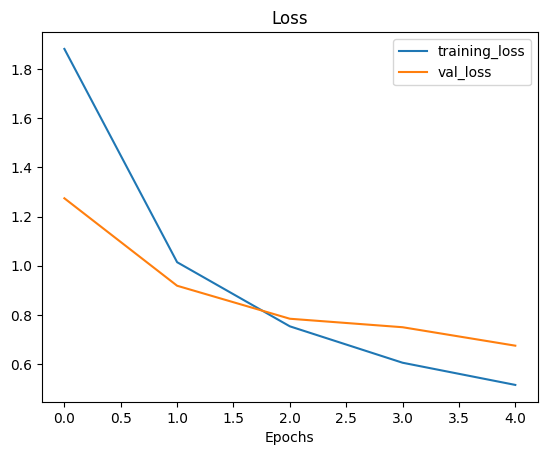

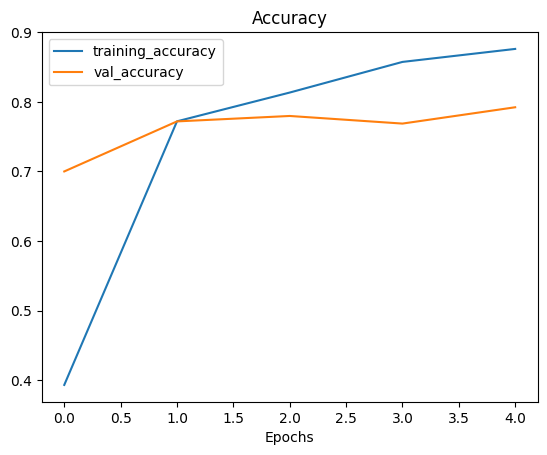

In [13]:
plot_loss_curves(history_0)

### Practice Functional ApI method of building the model
1. using efficientnet
2. using resnet

In [15]:
# using efficeintnet:
import tensorflow as tf
base_model_efficinetnet = tf.keras.applications.EfficientNetB0(include_top=False)

base_model_efficinetnet.trainable=False

inputs = tf.keras.layers.Input(shape=(128,128,3),
                               name="input_layer")

x = base_model_efficinetnet(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="GAP")(x)

outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax,name="output_layer")(x)

model_efficinetnet = tf.keras.Model(inputs,outputs)

model_efficinetnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

history_efficientnet = model_efficinetnet.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data))

Epoch 1/5
47/47 [==============================] - 6s 45ms/step - loss: 1.8477 - accuracy: 0.4000 - val_loss: 1.2552 - val_accuracy: 0.6922
Epoch 2/5
47/47 [==============================] - 1s 27ms/step - loss: 1.0273 - accuracy: 0.7413 - val_loss: 0.9087 - val_accuracy: 0.7609
Epoch 3/5
47/47 [==============================] - 1s 26ms/step - loss: 0.7578 - accuracy: 0.8080 - val_loss: 0.7779 - val_accuracy: 0.7828
Epoch 4/5
47/47 [==============================] - 1s 27ms/step - loss: 0.6233 - accuracy: 0.8480 - val_loss: 0.7209 - val_accuracy: 0.7906
Epoch 5/5
47/47 [==============================] - 1s 27ms/step - loss: 0.5261 - accuracy: 0.8760 - val_loss: 0.6782 - val_accuracy: 0.7984


In [16]:
model_efficinetnet.evaluate(test_data)

157/157 [==============================] - 2s 14ms/step - loss: 0.6562 - accuracy: 0.8088


[0.656178891658783, 0.8087999820709229]

In [17]:
# ResnetV2
base_model_resnet = tf.keras.applications.ResNet50(include_top=False)

base_model_resnet.trainable=False

inputs = tf.keras.layers.Input(shape=(128,128,3),
                               name="input_layer")

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model_resnet(x)

x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)

outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

model_resnet = tf.keras.Model(inputs,outputs)

model_resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_resnet = model_resnet.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data))

94765736/94765736 [==============================] - 6s 0us/step
Epoch 1/5
47/47 [==============================] - 5s 57ms/step - loss: 2.3589 - accuracy: 0.0840 - val_loss: 2.3053 - val_accuracy: 0.1266
Epoch 2/5
47/47 [==============================] - 1s 27ms/step - loss: 2.3144 - accuracy: 0.0947 - val_loss: 2.2976 - val_accuracy: 0.1391
Epoch 3/5
47/47 [==============================] - 1s 27ms/step - loss: 2.3095 - accuracy: 0.1027 - val_loss: 2.2891 - val_accuracy: 0.1234
Epoch 4/5
47/47 [==============================] - 1s 27ms/step - loss: 2.2932 - accuracy: 0.1160 - val_loss: 2.2855 - val_accuracy: 0.1359
Epoch 5/5
47/47 [==============================] - 1s 27ms/step - loss: 2.2852 - accuracy: 0.1547 - val_loss: 2.2838 - val_accuracy: 0.1500


In [18]:
## EfficientNet -> practice
base_model_efficinetnet = tf.keras.applications.EfficientNetB7(include_top=False)
base_model_efficinetnet.trainable=False
inputs = tf.keras.layers.Input(shape=(128,128,3))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(x)
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)
model_efficinetnet = tf.keras.Model(inputs,outputs)
model_efficinetnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                           metrics=["accuracy"])
history_efficientnet = model_efficinetnet.fit(train_data,
                                              epochs=8,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=(0.25*len(test_data)))

258076736/258076736 [==============================] - 18s 0us/step
Epoch 1/8
47/47 [==============================] - 6s 46ms/step - loss: 1.6692 - accuracy: 0.4800 - val_loss: 1.0409 - val_accuracy: 0.7375
Epoch 2/8
47/47 [==============================] - 1s 26ms/step - loss: 0.8500 - accuracy: 0.7560 - val_loss: 0.7966 - val_accuracy: 0.7703
Epoch 3/8
47/47 [==============================] - 1s 27ms/step - loss: 0.6170 - accuracy: 0.8453 - val_loss: 0.7179 - val_accuracy: 0.7828
Epoch 4/8
47/47 [==============================] - 1s 26ms/step - loss: 0.5021 - accuracy: 0.8760 - val_loss: 0.6559 - val_accuracy: 0.7984
Epoch 5/8
47/47 [==============================] - 1s 26ms/step - loss: 0.4092 - accuracy: 0.9187 - val_loss: 0.6310 - val_accuracy: 0.7937
Epoch 6/8
47/47 [==============================] - 1s 26ms/step - loss: 0.3396 - accuracy: 0.9427 - val_loss: 0.6194 - val_accuracy: 0.7984
Epoch 7/8
47/47 [==============================] - 1s 26ms/step - loss: 0.3038 - accuracy: 0

In [19]:
### Last practice with resnet and efficient -> combined
base_model_eff = tf.keras.applications.EfficientNetB7(include_top=False)
base_model_res = tf.keras.applications.ResNet50(include_top=False)
base_model_eff_base = tf.keras.applications.EfficientNetB0(include_top=False)

base_model_eff.trainable=False
base_model_res.trainable=False
base_model_eff_base.trainable=False

inputs = tf.keras.Input(shape=(128,128,3),
                         name="input_layer")

norm = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model_eff(inputs)
y = base_model_res(norm)
z = base_model_eff_base(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(x)
y = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(y)
z = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(z)

outputs1 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)
outputs2 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(y)
outputs3 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(z)

model_eff = tf.keras.Model(inputs,outputs1)
model_res = tf.keras.Model(inputs,outputs2)
model_eff_base = tf.keras.Model(inputs,outputs3)

model_eff.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                  metrics=['accuracy'])
model_res.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                  metrics=['accuracy'])
model_eff_base.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                  metrics=['accuracy'])

history_eff = model_eff.fit(train_data,
                            epochs=8,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data)*0.25)
history_res = model_res.fit(train_data,
                            epochs=8,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data)*0.25)
history_eff_base = model_eff_base.fit(train_data,
                            epochs=8,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data)*0.25)

model_eff.evaluate(test_data)
model_res.evaluate(test_data)
model_eff_base.evaluate(test_data)

Epoch 1/8
47/47 [==============================] - 21s 172ms/step - loss: 1.5811 - accuracy: 0.5053 - val_loss: 1.0806 - val_accuracy: 0.6687
Epoch 2/8
47/47 [==============================] - 5s 104ms/step - loss: 0.9061 - accuracy: 0.7413 - val_loss: 0.9124 - val_accuracy: 0.7109
Epoch 3/8
47/47 [==============================] - 5s 105ms/step - loss: 0.7171 - accuracy: 0.7987 - val_loss: 0.8324 - val_accuracy: 0.7297
Epoch 4/8
47/47 [==============================] - 5s 105ms/step - loss: 0.6220 - accuracy: 0.8373 - val_loss: 0.8110 - val_accuracy: 0.7359
Epoch 5/8
47/47 [==============================] - 5s 106ms/step - loss: 0.5223 - accuracy: 0.8733 - val_loss: 0.7728 - val_accuracy: 0.7328
Epoch 6/8
47/47 [==============================] - 5s 105ms/step - loss: 0.4532 - accuracy: 0.8800 - val_loss: 0.7569 - val_accuracy: 0.7484
Epoch 7/8
47/47 [==============================] - 5s 105ms/step - loss: 0.3829 - accuracy: 0.9093 - val_loss: 0.7468 - val_accuracy: 0.7437
Epoch 8/8
47

[0.5829617381095886, 0.8155999779701233]

#### Transfer learnig feature extraction

In [20]:
#1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model (so that the underlying pre-trained weights arents updated)
base_model.trainable=False

#3. Create inputs for model
inputs = tf.keras.Input(shape=(128,128,3),
                        name="input_layer")

#4.(optional) If using ResNet50V2 -> need to normalize the inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base model
x = base_model(inputs)
print("shape after passing inputs through base model: "+str(x.shape))

#6. Average pool the outputs of the base_model(aggregate all the most important information, reduce the number of computatuions)
x = tf.keras.layers.GlobalAveragePooling2D(name="avgPool")(x)
print("shape after GlobalAveragePooling2D: "+str(x.shape))

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

#8. Combine the inputs and outputs
model_1 = tf.keras.Model(inputs,outputs)

#9. Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#10. Fit the model and save the history
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data))

shape after passing inputs through base model: (None, 4, 4, 1280)
shape after GlobalAveragePooling2D: (None, 1280)
Epoch 1/5
47/47 [==============================] - 6s 46ms/step - loss: 1.8412 - accuracy: 0.3960 - val_loss: 1.2586 - val_accuracy: 0.6812
Epoch 2/5
47/47 [==============================] - 1s 26ms/step - loss: 1.0113 - accuracy: 0.7507 - val_loss: 0.9068 - val_accuracy: 0.7688
Epoch 3/5
47/47 [==============================] - 1s 26ms/step - loss: 0.7491 - accuracy: 0.8187 - val_loss: 0.7945 - val_accuracy: 0.7781
Epoch 4/5
47/47 [==============================] - 1s 26ms/step - loss: 0.6209 - accuracy: 0.8440 - val_loss: 0.7182 - val_accuracy: 0.7891
Epoch 5/5
47/47 [==============================] - 1s 26ms/step - loss: 0.5271 - accuracy: 0.8693 - val_loss: 0.6913 - val_accuracy: 0.7891


In [21]:
#Evaluate the model
model_1.evaluate(test_data)

157/157 [==============================] - 2s 14ms/step - loss: 0.6581 - accuracy: 0.8080


[0.6581257581710815, 0.8080000281333923]

In [22]:
# Check the layers in the base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer)

0 <keras.src.engine.input_layer.InputLayer object at 0x7f74108eca30>
1 <keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f74202f4fa0>
2 <keras.src.layers.preprocessing.normalization.Normalization object at 0x7f72adbd0070>
3 <keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f74213c35b0>
4 <keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f72b5acdd00>
5 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f74202f46a0>
6 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f72cc24aa30>
7 <keras.src.layers.core.activation.Activation object at 0x7f74382d52b0>
8 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f72cc2b5b20>
9 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f72ad1b8a60>
10 <keras.src.layers.core.activation.Activation object at 0x7f72ad1b8cd0>
11 <keras.src.layers.pooling.global_average_pooling2d.GlobalAverag

### Getting Feature vector from trained model
Let's demonstrate GlobalAveragePooling2D layer...

let us use shape=(1,4,4,3) and pass it to GlobalAveragePooling2D

In [23]:
input_shape=(1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(shape=input_shape)
print("Random input tensor: \n"+str(input_tensor))

#pass the random tensor through a global average pooling layer
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print("\n\nAfter passing through pooling layer \n"+str(global_average_pooling_tensor))
print("\n\nShape of input tensor: "+str(input_tensor.shape))
print("\n\nShape of pooling layer: "+str(global_average_pooling_tensor.shape))

Random input tensor: 
tf.Tensor(
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]], shape=(1, 4, 4, 3), dtype=float32)


After passing through pooling layer 
tf.Tensor([[-0.0936 -0.4585 -0.2886]], shape=(1, 3), dtype=float16)


Shape of input tensor: (1, 4, 4, 3)


Shape of pooling layer: (1, 3)


In [24]:
### Let's replicate globalaveragepool2D layer
tf.reduce_mean(input_tensor,axis=[1,2]) #mean along the axis 1 and 2

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [25]:
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338894,  0.97772694],
         [ 0.24694404,  0.20573746, -0.52562326],
         [ 0.32410017,  0.02545409, -0.10638496],
         [-0.63694745,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815628,  0.23479679, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [26]:
# Use GlobalMaxPool2D
print("Shape before passing:\n",input_shape)
x = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print("\nAfter passing through global max pool layer:\n",x)
print("\nshape after passing: ",x.shape)

Shape before passing:
 (1, 4, 4, 3)

After passing through global max pool layer:
 tf.Tensor([[0.906 1.16  1.699]], shape=(1, 3), dtype=float16)

shape after passing:  (1, 3)


### Running a series of transfer learning experiments
0. model_0  -> baseline
1. use 1% data  -> model_1
2. 10% data - feature extraction with data augmentation -> model_2
3. 10% data - fine tuning with data augmentation    -> model_3
4. 100% data - fine tuning with data augmentation   -> model_4

#### MODEL1

In [27]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-01-01 00:34:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4007:818::201b, 2404:6800:4007:819::201b, 2404:6800:4007:81a::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4007:818::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  17.9MB/s    in 9.3s    

2024-01-01 00:34:36 (13.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [28]:
#Create training and testing dir
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [29]:
#setup data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=(128,128),
                                                                           batch_size=16)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(128,128),
                                                                batch_size=16)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Adding data augmentation into the model
* we can use the layers inside:
    * tf.keras.layers.experimental.preprocessing()

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    #tf.keras.layers.experimental.preprocessing.Rescale(1./255), #-> keep it for ResNetV2, efficientNet already has it
],name="data_augmentation")

10_food_classes_1_percent/train/ice_cream/919447.jpg


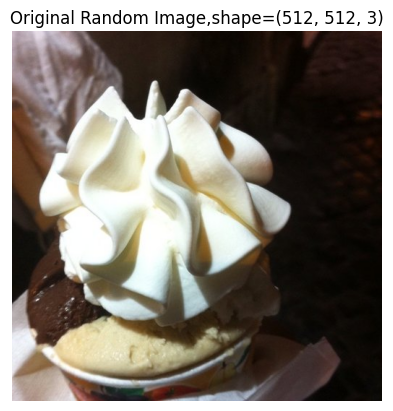

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 640x480 with 1 Axes>

In [31]:
### Visualise the data augmentation and see what happens to the data
# View a random image and compare it with its augmentaed image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image
print(random_image_path)

#Read and plot the image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original Random Image,shape={img.shape}")
plt.axis(False)
plt.show()

#Plot the augmented image
augmented_img = data_augmentation(img,training=True)
plt.imshow(augmented_img/255)   # -> clipping images -> not normalised
plt.title(f"Same image but augmented,shape={augmented_img.shape}")
plt.axis(False)
plt.show()

#print(img)

In [32]:
## model_1 : Feature extraction transfer learinng with data augmentation

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=(128,128),
                                                                           batch_size=16)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(128,128),
                                                                batch_size=16)

data_augmentation_1 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
],name="data_augmentation")

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs1 = tf.keras.layers.Input(shape=(128,128,3),
                               name="input_layer")
#Add augmentation layer
x = data_augmentation_1(inputs1,training=True)
x = base_model(x/255,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs1=tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

model_1 = tf.keras.Model(inputs1,outputs1)
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'],
                run_eagerly=True)
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240101-003440
Epoch 1/5
5/5 [==============================] - 17s 4s/step - loss: 2.3718 - accuracy: 0.1000 - val_loss: 2.3276 - val_accuracy: 0.0817
Epoch 2/5
5/5 [==============================] - 14s 3s/step - loss: 2.3191 - accuracy: 0.0857 - val_loss: 2.3390 - val_accuracy: 0.1010
Epoch 3/5
5/5 [==============================] - 14s 3s/step - loss: 2.3574 - accuracy: 0.0571 - val_loss: 2.3323 - val_accuracy: 0.1106
Epoch 4/5
5/5 [==============================] - 14s 3s/step - loss: 2.3302 - accuracy: 0.0857 - val_loss: 2.3104 - val_accuracy: 0.1026
Epoch 5/5
5/5 [==============================] - 14s 3s/step - loss: 2.3119 - accuracy: 0.1143 - val_loss: 2.3155 - val_accuracy: 0.0929


In [33]:
# Check out model summary
model_1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 tf.math.truediv (TFOpLambd  (None, None, None, 3)     0         
 a)                                                              
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [34]:
# Evaluate on full dataset
results_1_percent_data_aug = model_1.evaluate(test_data)

157/157 [==============================] - 33s 210ms/step - loss: 2.3176 - accuracy: 0.0964


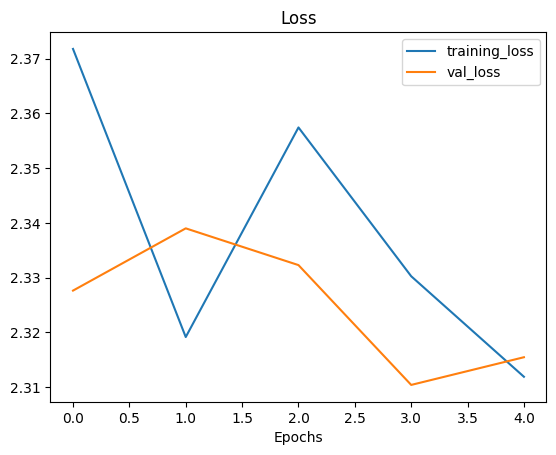

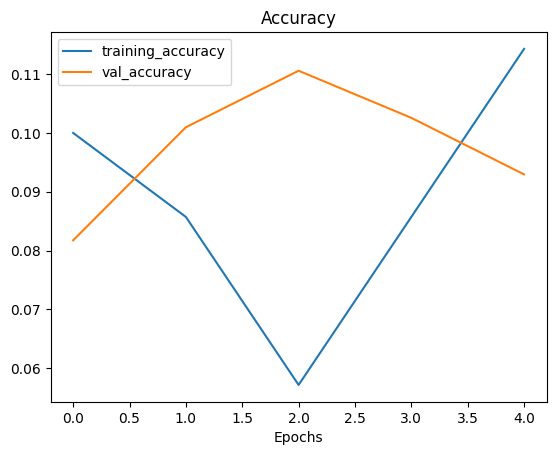

In [35]:
#Loss curves
plot_loss_curves(history_1_percent)

#### Model_2

In [36]:
### Model 2 with 10% food data, data augmentation and normal compilation with efficientNetB0 and fitting
## maintain the same test data to compare
import tensorflow as tf
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/train/",
                                                                           image_size=(128,128),
                                                                           label_mode="categorical",
                                                                           batch_size=16)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_1_percent/test/",
                                                                          image_size=(128,128),
                                                                          label_mode="categorical",
                                                                          batch_size=16)

data_augmentation_10_percent = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
],name="data_augmentation_10_percent")

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs_10_percent = tf.keras.layers.Input(shape=(128,128,3),
                                         name="input_layer")

x = data_augmentation_10_percent(inputs_10_percent,training=True)
x = base_model(x,training=False) # training=False because to keep the model is inference mode, so that batchnorm layer stays the same and dosen't change
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs_10_percent = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

model_2 = tf.keras.Model(inputs_10_percent,outputs_10_percent)
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'],
               run_eagerly=True)
hisotry_10_percent = model_2.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data_10_percent,
                                validation_steps=int(0.2*len(test_data_10_percent)))

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Epoch 1/5
47/47 [==============================] - 46s 982ms/step - loss: 1.9941 - accuracy: 0.3453 - val_loss: 1.5525 - val_accuracy: 0.5948
Epoch 2/5
47/47 [==============================] - 45s 971ms/step - loss: 1.3568 - accuracy: 0.6400 - val_loss: 1.2847 - val_accuracy: 0.6310
Epoch 3/5
47/47 [==============================] - 48s 1s/step - loss: 1.0729 - accuracy: 0.7013 - val_loss: 1.1433 - val_accuracy: 0.6573
Epoch 4/5
47/47 [==============================] - 53s 1s/step - loss: 0.9375 - accuracy: 0.7267 - val_loss: 1.1292 - val_accuracy: 0.6653
Epoch 5/5
47/47 [==============================] - 58s 1s/step - loss: 0.8497 - accuracy: 0.7533 - val_loss: 1.0173 - val_accuracy: 0.6815


157/157 [==============================] - 27s 173ms/step - loss: 0.9930 - accuracy: 0.6868


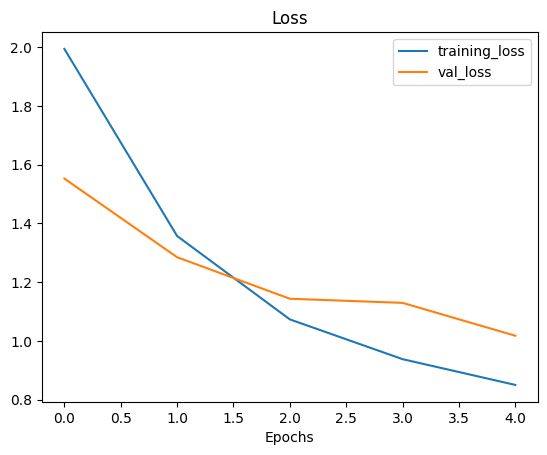

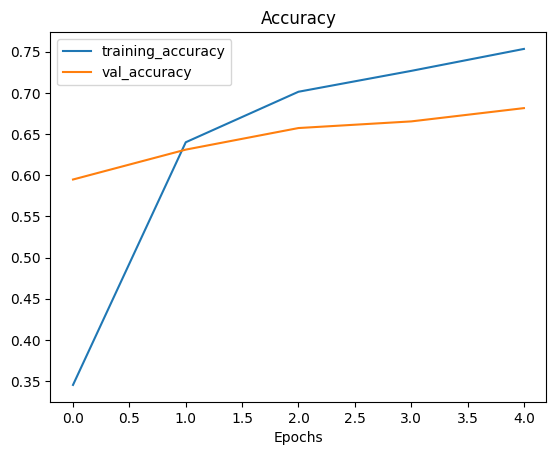

In [37]:
model_2.evaluate(test_data_10_percent)
plot_loss_curves(hisotry_10_percent)

In [38]:
model_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation_10_perce  (None, None, None, 3)     0         
 nt (Sequential)                                                 
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 10)                12810     
                                                           

### Creating a ModelCheckpoint callback
* Save the model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting
* *tf.keras.callbacks.ModelCheckpoint()*
* .ckpt -> extension

In [39]:
# Set check point path :
check_point_path = "10%_model_checkpoints_weights/save.ckpt"

# Create a model checkpoint that saves models's weight
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = check_point_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",# save every epoch,
                                                         verbose=1)

In [40]:
# Fit the model of 10% data and use the above created callback
train_data = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/train",
                                                       image_size=(128,128),
                                                       batch_size=16,
                                                       label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/test",
                                                      image_size=(128,128),
                                                      batch_size=16,
                                                      label_mode="categorical")
data_augmentation_10_percent = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
],name="data_augmentation_10_percent")

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs = tf.keras.Input(shape=(128,128,3))
x = data_augmentation_10_percent(inputs,training=True)
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

model_2_checkpoint_callback = tf.keras.Model(inputs,outputs)
model_2_checkpoint_callback.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                    optimizer=tf.keras.optimizers.Adam(),
                                    metrics=['accuracy'])
history_2_checkpoint_callback = model_2_checkpoint_callback.fit(train_data,
                                                                epochs=5,
                                                                steps_per_epoch=len(train_data),
                                                                validation_data = test_data,
                                                                validation_steps=int(0.25*len(test_data)),
                                                                callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), checkpoint_callback])

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240101-004108
Epoch 1/5
47/47 [==============================] - ETA: 0s - loss: 1.9664 - accuracy: 0.3293
Epoch 1: saving model to 10%_model_checkpoints_weights/save.ckpt
47/47 [==============================] - 12s 164ms/step - loss: 1.9664 - accuracy: 0.3293 - val_loss: 1.5454 - val_accuracy: 0.5625
Epoch 2/5
47/47 [==============================] - ETA: 0s - loss: 1.3271 - accuracy: 0.6360
Epoch 2: saving model to 10%_model_checkpoints_weights/save.ckpt
47/47 [==============================] - 6s 136ms/step - loss: 1.3271 - accuracy: 0.6360 - val_loss: 1.2331 - val_accuracy: 0.6250
Epoch 3/5
47/47 [==============================] - ETA: 0s - loss: 1.0535 - accuracy: 0.7120
Epoch 3: saving model to 10%_model_checkpoints_weights/save.ckpt
47/47 [==============================] - 6s 118ms/step - loss: 1.0535 - accuracy: 0.7120 - va

In [41]:
model_0.evaluate(test_data)

157/157 [==============================] - 3s 14ms/step - loss: 0.6586 - accuracy: 0.8040


[0.6586390733718872, 0.8040000200271606]

In [42]:
before_saving = model_2_checkpoint_callback.evaluate(test_data)

157/157 [==============================] - 9s 55ms/step - loss: 0.9804 - accuracy: 0.7008


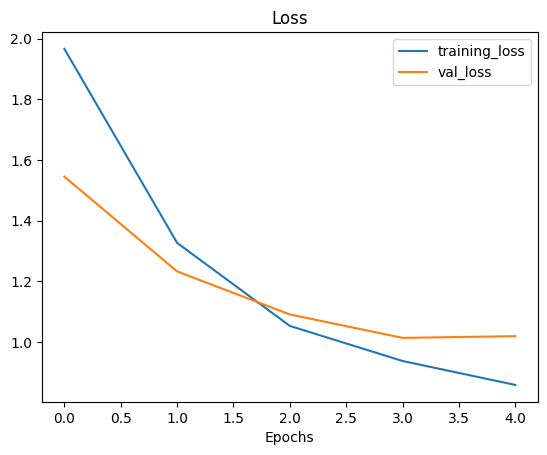

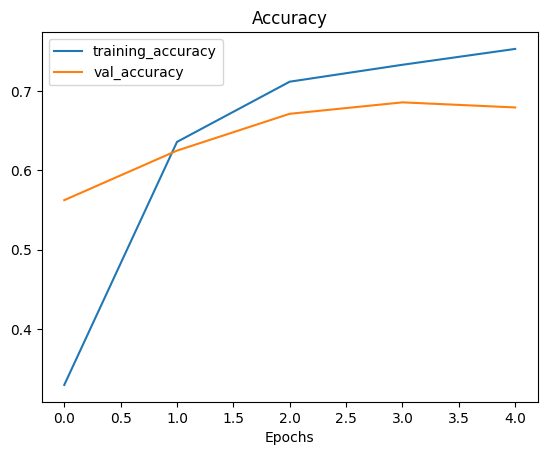

In [43]:
#Plot loss curves
plot_loss_curves(history_2_checkpoint_callback)

### Loading in checkpointed weights
Loading in cehckpointed weights returns a model to specific checkpoint

In [44]:
# Load the model
model_2_checkpoint_callback.load_weights(check_point_path)

In [45]:
#Evaluate model_2 with loaded weights
after_loading = model_2_checkpoint_callback.evaluate(test_data)

157/157 [==============================] - 9s 59ms/step - loss: 0.9900 - accuracy: 0.6884


In [46]:
after_loading == before_saving

False

It says false because of change in precision points depends on the way they are stored in the system

In [47]:
# Check to see if loaded model results are same as before saving model resutls
import numpy as np
np.isclose(np.array(after_loading),np.array(before_saving)) # it is same, but there is minor changes due to how it is stored

array([False, False])

In [48]:
# Check the difference between two results:
np.array(after_loading) - np.array(before_saving)

array([ 0.00958747, -0.01240003])

#### MODEL 3
Fine tuning: some layers can be unfrozen in the imported model to improve model learning the patterns

In [49]:
# Use 10% data
model_2.layers

In [50]:
model_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation_10_perce  (None, None, None, 3)     0         
 nt (Sequential)                                                 
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 10)                12810     
                                                           

In [51]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f75283bb640> True
<keras.src.engine.sequential.Sequential object at 0x7f75283bb2b0> True
<keras.src.engine.functional.Functional object at 0x7f752805a400> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f75281891c0> True
<keras.src.layers.core.dense.Dense object at 0x7f75283b62b0> True


In [52]:
# What layers are there in base_model:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_11 False
1 rescaling_16 False
2 normalization_7 False
3 rescaling_17 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze F

In [53]:
print(len(model_2.layers[2].trainable_variables))

0


In [54]:
# To begin fine tuning, lets start by setting last 10 layers of base model trainable to true
#base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False

# Recompile the entire model everytime there is a change
model_2_checkpoint_callback.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate by 10 times so taht new unfrozen layers dosen't learn too much and become useless
                metrics=['accuracy'])


In [55]:
# Check for layers thats are trainabale
for i, layer in enumerate(model_2_checkpoint_callback.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_12 False
1 rescaling_18 False
2 normalization_8 False
3 rescaling_19 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze F

In [56]:
print(len(model_2_checkpoint_callback.trainable_variables))

12


In [57]:
model_2_checkpoint_callback.trainable_variables

[<AutoCastVariable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32 dtype_to_cast_to=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <AutoCastVariable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32 dtype_to_cast_to=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966,

In [58]:
#Fine tune it for another 5 epochs
history_2_fine_tune = model_2_checkpoint_callback.fit(train_data,
                                                      epochs=10,
                                                      validation_data=test_data,
                                                      validation_steps=int(0.25*len(test_data)),
                                                      steps_per_epoch=len(train_data),
                                                      initial_epoch=history_2_checkpoint_callback.epoch[-1], # start training from previous last epoch
                                                      callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240101-004205
Epoch 5/10
47/47 [==============================] - 11s 115ms/step - loss: 0.7237 - accuracy: 0.7907 - val_loss: 0.8777 - val_accuracy: 0.7196
Epoch 6/10
47/47 [==============================] - 5s 101ms/step - loss: 0.5909 - accuracy: 0.8187 - val_loss: 0.8413 - val_accuracy: 0.7228
Epoch 7/10
47/47 [==============================] - 4s 95ms/step - loss: 0.5645 - accuracy: 0.8147 - val_loss: 0.8887 - val_accuracy: 0.7003
Epoch 8/10
47/47 [==============================] - 4s 88ms/step - loss: 0.5134 - accuracy: 0.8560 - val_loss: 0.8841 - val_accuracy: 0.7147
Epoch 9/10
47/47 [==============================] - 4s 80ms/step - loss: 0.4803 - accuracy: 0.8520 - val_loss: 0.8586 - val_accuracy: 0.7292
Epoch 10/10
47/47 [==============================] - 4s 96ms/step - loss: 0.4238 - accuracy: 0.8653 - val_loss: 0.8947 - val_accuracy: 0.6987


In [59]:
# EValuate the model
fine_tune_result = model_2_checkpoint_callback.evaluate(test_data)

157/157 [==============================] - 7s 43ms/step - loss: 0.8617 - accuracy: 0.7196


In [60]:
after_loading,fine_tune_result

([0.9900109171867371, 0.6883999705314636],
 [0.8616598844528198, 0.7196000218391418])

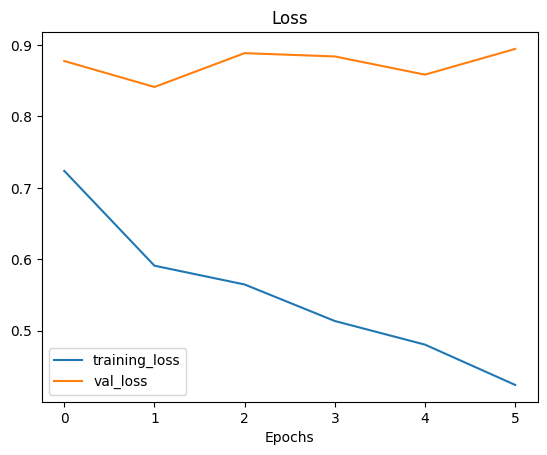

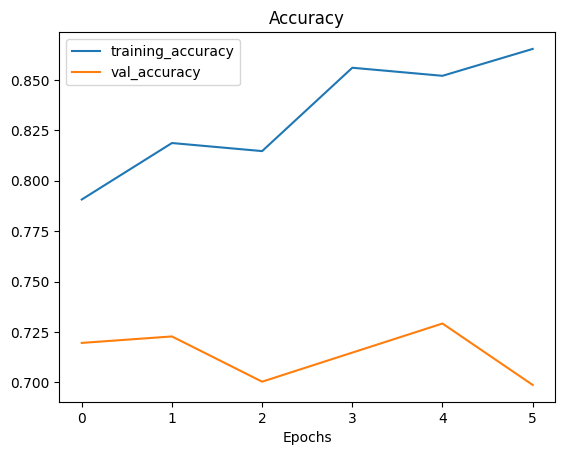

In [61]:
#Check loss curves
plot_loss_curves(history_2_fine_tune)

In [62]:
# Create function to create loss curves before and after fine tuning
def compare_history(original,final,initial_epoch=5):
  acc = original.history["accuracy"]
  loss=original.history["loss"]

  val_acc = original.history["val_accuracy"]
  val_loss=original.history["val_loss"]

  total_acc = acc + final.history["accuracy"]
  total_loss = loss + final.history["loss"]

  total_val_acc = val_acc + final.history["val_accuracy"]
  total_val_loss = val_loss + final.history["val_loss"]

  plt.figure(figsize=(8,4))
  plt.plot(total_acc,label='Training Accuracy')
  plt.plot(total_val_acc, label="Val accuracy")
  plt.plot([initial_epoch-1, initial_epoch-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='lower right')
  plt.show()
  plt.figure(figsize=(8,4))
  plt.title('Training and Validation Accuracy')
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epoch-1, initial_epoch-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


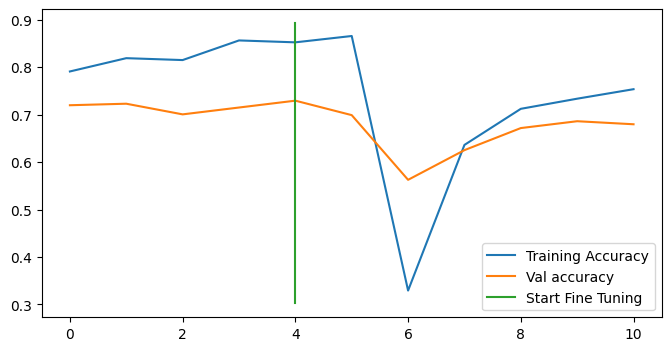

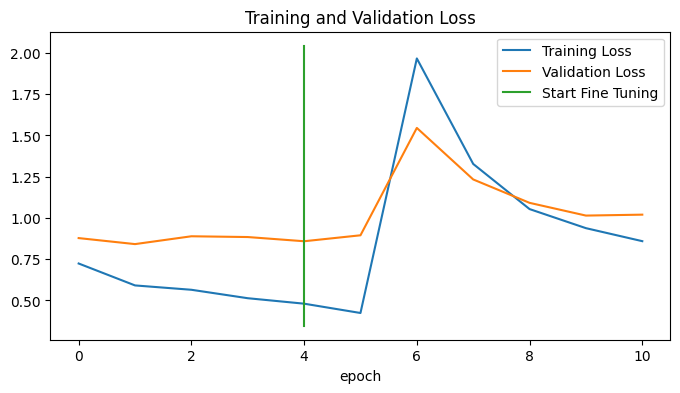

In [63]:
import matplotlib.pyplot as plt
compare_history(history_2_fine_tune,history_2_checkpoint_callback)

#### MODEL 4
100% data

In [64]:
#Download and unzipt the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-01-01 00:42:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4007:808::201b, 2404:6800:4007:819::201b, 2404:6800:4007:81a::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4007:808::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  12.4MB/s    in 43s     

2024-01-01 00:43:28 (11.6 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [65]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 

In [66]:
train_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_all_data/train",
                                                              image_size=(224,224),
                                                              label_mode="categorical",
                                                              batch_size=32)
test_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_all_data/test",
                                                                label_mode="categorical",
                                                                image_size=(224,224),
                                                                batch_size=32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [67]:
# Evaluate model3 -> fine tuned model
model_2_checkpoint_callback.evaluate(test_data)

157/157 [==============================] - 7s 43ms/step - loss: 0.8557 - accuracy: 0.7160


[0.8557062745094299, 0.7160000205039978]

In [68]:
fine_tune_result

[0.8616598844528198, 0.7196000218391418]

To train a fine tuning model (model_4), we need to revert model_2 back to its feature extraction weights

In [69]:
model_2_checkpoint_callback.evaluate(test_data)

157/157 [==============================] - 6s 37ms/step - loss: 0.8678 - accuracy: 0.7148


[0.8677847385406494, 0.7148000001907349]

In [70]:
before_saving

[0.9804234504699707, 0.7008000016212463]

In [71]:
model_2_checkpoint_callback.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 data_augmentation_10_perce  (None, None, None, 3)     0         
 nt (Sequential)                                                 
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 10)                12810     
                                                          

In [72]:
#Load weights from check point
model_2_checkpoint_callback.load_weights(check_point_path)

ValueError: Received incompatible tensor with shape (1280, 10) when attempting to restore variable with shape (1, 1, 1152, 48) and name cond_1/Adam/m/block7a_se_reduce/kernel:0.

In [ ]:
for i, layer in enumerate(model_2_checkpoint_callback.layers):
  print(1,layer.name,layer.trainable) # Even if single layer is trainable in a big series of layers, whole series is considered trainable

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i,layer.name,layer.trainable)

In [ ]:
history_2_checkpoint_callback.epoch

In [ ]:
#Compile
model_2_checkpoint_callback.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                    metrics=['accuracy'])
history_100_percent_data = model_2_checkpoint_callback.fit(train_data_100_percent,
                                                           epochs=10,
                                                           initial_epoch=history_2_checkpoint_callback.epoch[-1],
                                                           steps_per_epoch=len(train_data_100_percent),
                                                           validation_data=test_data_100_percent,
                                                           validation_steps=int(0.25*len(test_data_100_percent)),
                                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

In [ ]:
#Evaluate on whole test data
finetune_full_data = model_2_checkpoint_callback.evaluate(test_data_100_percent)
finetune_full_data

In [ ]:
compare_history(history_2_checkpoint_callback,history_100_percent_data)

## Viewing experiment on tensorboard

In [ ]:
## Viewing experiment on tensorboard
#View logs
# upload record
# !tensorboard dev upload --logdir ./transfer_learning \
#   --name "Transfer learning experiments with 10 Food101 classes" \
#   --description "A series of different transfer learning experiments with varying amounts of data and fine tuning" \
#   --one_shot #Exits the uplaoder once its finished

#Challenge:
**Recreate one of the experiments we did with the EfficientNetB4 architecture in the tf.keras.applications module.**

* Create basic model and check with/without data augmentation
* Fine tune that model on full dataset

In [ ]:
from tensorflow.python import training
# Baseic model
train_data_100_challenge = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_all_data/train",
                                                                               batch_size=32,
                                                                               image_size=(224,224),
                                                                               label_mode="categorical",
                                                                               shuffle=True)
test_data_100_challenge = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_all_data/test",
                                                                              batch_size=32,
                                                                              image_size=(224,224),
                                                                              label_mode="categorical",
                                                                              shuffle=True)

initial_epoch = 5

data_aug_challenge = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
],name="data_aug_challenge")

base_model_challenge = tf.keras.applications.EfficientNetB4(include_top=False)
base_model_challenge.trainable=False

inputs = tf.keras.Input(shape=(224,224,3),
                        name="input_layer_challenge")

x1 = base_model_challenge(inputs)
x2 = data_aug_challenge(inputs,training=True)

x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)

x2 = base_model_challenge(x2,training=False)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

outputs1 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x1)
outputs2 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x2)

model_challenge_no_aug = tf.keras.Model(inputs,outputs1)
model_challenge_aug = tf.keras.Model(inputs,outputs2)

model_challenge_no_aug.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                               optimizer=tf.keras.optimizers.Adam(),
                               metrics=['accuracy'])
print("Running model without data augmentation and using model checkpoint")
history_challenge_no_aug = model_challenge_no_aug.fit(train_data_100_challenge,
                                                      epochs=initial_epoch,
                                                      steps_per_epoch=len(train_data_100_challenge),
                                                      validation_data=test_data_100_challenge,
                                                      validation_steps=int(0.25*len(test_data_100_challenge)),
                                                      callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="ChallengeQuesion/noAug",
                                                                                                    save_best_only=False,
                                                                                                    save_weights_only=True,
                                                                                                    save_freq="epoch")])

print("Running model with data augmentation and using model checkpoint")
model_challenge_aug.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])
history_challenge_aug = model_challenge_aug.fit(train_data_100_challenge,
                                                epochs=initial_epoch,
                                                steps_per_epoch=len(train_data_100_challenge),
                                                validation_data=test_data_100_challenge,
                                                validation_steps=int(0.25*len(test_data_100_challenge)),
                                                callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="ChallengeQuesion/Aug",
                                                                                              save_best_only=False,
                                                                                              save_weights_only=True,
                                                                                              save_freq="epoch")])

In [ ]:
print(model_challenge_no_aug.evaluate(test_data_100_challenge))
print(model_challenge_aug.evaluate(test_data_100_challenge))

Model without data augmentation did better
Use the model that didnt undergo data augmentation for fine tuning and train it on full data

In [ ]:
model_challenge_no_aug.load_weights("ChallengeQuesion/noAug")
model_challenge_no_aug.evaluate(test_data_100_challenge)

In [ ]:
base_model_challenge.trainable=True
for layer in base_model_challenge.layers[:-10]:
  layer.tranable=False

#Recompile
model_challenge_no_aug.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                               metrics=['accuracy'])
history_finetune_challenge = model_challenge_no_aug.fit(train_data_100_challenge,
                                                        epochs=initial_epoch+5,
                                                        steps_per_epoch=len(train_data_100_challenge),
                                                        initial_epoch = history_challenge_no_aug.epoch[-1],
                                                        validation_data=test_data_100_challenge,
                                                        validation_steps=int(0.25*len(test_data_100_challenge)))

In [ ]:
compare_history(history_challenge_no_aug,history_finetune_challenge)

# EXERCISE
🛠 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises
1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.
2. Fine-tune the last 20 layers of the base model you trained in 1 for another 10 epochs. How did it go?
3. Fine-tune the last 30 layers of the base model you trained in 1 for another 10 epochs. How did it go?
4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [ ]:
# 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/train",
                                                                            batch_size=32,
                                                                            label_mode="categorical",
                                                                            shuffle=True,
                                                                            image_size=(224,224))
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/test",
                                                                           batch_size=32,
                                                                           label_mode="categorical",
                                                                           shuffle=True,
                                                                           image_size=(224,224))

base_model_10_percent = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.Input(shape=(224,224,3))
x =base_model_10_percent(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)
model_10_percent = tf.keras.Model(inputs,outputs)
model_10_percent.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=['accuracy'])
history_10_percent = model_10_percent.fit(train_data_10_percent,
                                          epochs=10,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data_10_percent,
                                          validation_steps=int(0.25*len(test_data_10_percent)),
                                          callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="Exercise1/save.ckpt",
                                                                                        save_weights_only=True,
                                                                                        save_freq="epoch",
                                                                                        save_best_only=False)])

In [ ]:
initial_epoch=10
base_result = model_10_percent.evaluate(test_data_10_percent)
base_result

In [ ]:
# 2. Fine-tune the last 20 layers of the base model you trained in 1 for another 10 epochs.
base_model_10_percent.trainable=True
for layer in base_model_10_percent.layers[:-20]:
  layer.trainable=False

model_10_percent.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=['accuracy'])
history_20_finetune = model_10_percent.fit(train_data_10_percent,
                                           epochs=initial_epoch+10,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data_10_percent,
                                           validation_steps=int(0.25*len(test_data_10_percent)),
                                           initial_epoch=history_10_percent.epoch[-1])

In [ ]:
finetune_20 = model_10_percent.evaluate(test_data_10_percent)
finetune_20

In [ ]:
# 3.Fine-tune the last 30 layers of the base model you trained in 1 for another 10 epochs.
model_10_percent.load_weights("Exercise1/save.ckpt")
model_10_percent.evaluate(test_data_10_percent)

In [ ]:
base_result

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-30]:
  layer.trainable=False

model_10_percent.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=['accuracy'])
history_30_finetune = model_10_percent.fit(train_data_10_percent,
                                           epochs=initial_epoch+10,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data_10_percent,
                                           validation_steps=int(0.25*len(test_data_10_percent)),
                                           initial_epoch=history_10_percent.epoch[-1])

In [ ]:
train_data_10_percent.class_names

In [ ]:
import os
s = "10_food_classes_all_data/train/pizza"
type(os.listdir(s))

In [ ]:
# 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.
def visualise_and_predict(model,dataset="10_food_classes_all_data/"):
  import random as r
  import matplotlib.pyplot as plt
  import os
  #Visualising part
  x = ["train","test"]
  choice_folder = r.choice(x)
  path = dataset+choice_folder
  data = tf.keras.preprocessing.image_dataset_from_directory(path,
                                                             batch_size=32,
                                                             image_size=(224,224),
                                                             shuffle=True,
                                                             label_mode="categorical")
  print("Available classes : ",data.class_names)
  l = data.class_names
  class_choice = r.choice(l)
  print("\nClass of image being shown: ",class_choice)
  image_path = path+"/"+class_choice+"/"
  img_choice = r.choice(os.listdir(image_path))
  image = plt.imread(image_path+img_choice)
  plt.imshow(image)
  plt.show()

  #Predicting part
  image = tf.image.resize(image,(224,224))
  print("Model prediciton: ")
  ans = model.predict(tf.expand_dims(image,axis=0))
  index = tf.argmax(ans[0])
  print("The model provided, predited the above image to be :",data.class_names[index])
  print("Prediction percentage :",ans[0][index]*100,"%")

In [ ]:
visualise_and_predict(model_challenge_no_aug)